In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# **1) DATA GENERATING PROCESS**

In [2]:
def generate_z(K,x_data):
    z_O = []
    z_E = []
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
        z_E.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [3]:
def generate_q_p(K,mean,x_data,z,z_O,z_E):
    q = []
    p = []
    q_O = []
    p_O = []
    q_E = []
    p_E = []
    for i in range(int(2**(K+1))):
        q.append(multivariate_normal.pdf(z[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p.append(multivariate_normal.pdf(z[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z[i], cov=np.identity(20)))
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_O[i], cov=np.identity(20)))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_E[i], cov=np.identity(20)))
    return q, p, q_O, p_O, q_E, p_E

# **2) THEORETICAL LIKELIHOOD**

In [4]:
def calcul_likelihood(x,theta):
  cste = (2*np.pi)**(-len(x)/2)*1/(np.sqrt(np.linalg.det(2*np.identity(20))))
  somme = 0
  for i in range(len(x)):
    somme += (x[i] - theta)**2
  return cste*np.exp(-somme/4)

# **3) SS ESTIMATOR**

### **a) Estimation function**

In [5]:
def SS_estimator(n_sim, mean, r, x_data):
    ss = []
    for i in range(n_sim):
        K = np.random.geometric(r, 1)
        z, z_O, z_E = generate_z(K,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = np.log(p_O) - np.log(q_O)
        w_E = np.log(p_E) - np.log(q_E)
            
        #third step : compute I0
        I0 = w.mean()

        #fourth step : compute Lo and Le
            # Lo
        l_O = logsumexp(w_O) - np.log(len(w_O))    
            #Le
        l_E = logsumexp(w_E) - np.log(len(w_E))    

        #fifth step : compute L_O_E
        L_O_E = logsumexp(w) - np.log(len(w))
    
        #DeltaK
        DeltaK = L_O_E - 0.5*(l_O + l_E)
    
        #sixth step : compute the final estimator
        ml_ll_ss = I0 + (DeltaK/(r*(1-r)**(int(K)-1)))
        
        ss.append(ml_ll_ss)
    mean_value = np.mean(ss)
    #std_error_value = np.std(ss) / np.sqrt(len(ss))

    return mean_value

### **b) Plotting function**

In [6]:
def plot_ss(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(SS_estimator(n_sim=300, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

In [7]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_ss, y_ss = plot_ss(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)

Theta = -0.32
0.33
0.67
1.00


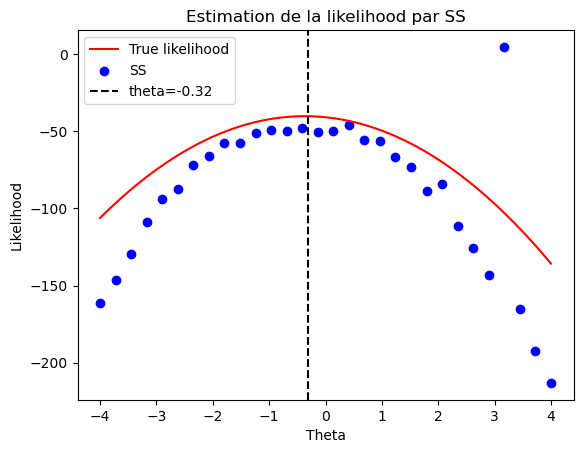

In [8]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(calcul_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_ss,y_ss, color='b', label='SS')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par SS')
plt.legend(loc='best')
plt.show()  

# **4) RUSSIAN ROULETTE ESTIMATOR**

### **a) Estimation function**

In [9]:
def delta(k, q, p, q_O, p_O, q_E, p_E):
    w_O_k = []
    w_E_k = []
    w_k=[]
    for i in range(2**k):
        w_O_k.append(p_O[i]/q_O[i])
        w_E_k.append(p_E[i]/q_E[i])
    for i in range(2**(k+1)):
        w_k.append(p[i]/q[i])
    l_O_k = logsumexp(w_O_k) - np.log(len(w_O_k))  
    l_E_k = logsumexp(w_E_k) - np.log(len(w_E_k))    
    l_k = logsumexp(w_k) - np.log(len(w_k))
    delta_k = l_k - 0.5*(l_E_k + l_O_k)
    return delta_k

In [10]:
def RR_estimator(n_sim, mean, r, x_data):
    rr = []
    for i in range(n_sim):
        sum_rr = 0
        K = np.random.geometric(r, 1)
        z, z_O, z_E = generate_z(K,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
            
        #third step : compute I0
        I0 = w.mean()
        
        for j in range(1,int(K)):
            sum_rr += (delta(j,q,p,q_O,p_O,q_E,p_E)/((1-r)**j))
            
        ml_ll_rr = I0 + sum_rr
        rr.append(ml_ll_rr)
        
    mean_value = np.mean(rr)
    #std_error_value = np.std(rr) / np.sqrt(len(rr))

    return mean_value

### **b) Plotting function**

In [11]:
def plot_rr(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(RR_estimator(n_sim=300, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

In [12]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_rr, y_rr = plot_rr(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)

Theta = -0.32
0.33
0.67
1.00


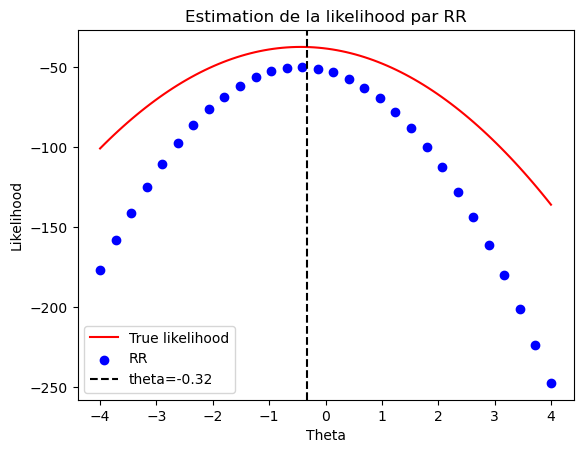

In [13]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(calcul_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_rr,y_rr, color='b', label='RR')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par RR')
plt.legend(loc='best')
plt.show()  

# **5) IWAE ESTIMATOR**

### **a) Estimation function**

In [14]:
def sum_w(k,w):
    sum_w=0
    for i in range(k):
        sum_w += np.exp(w[i])
    return sum_w

In [15]:
def iwae(n_sim,k,mean,x_data):
    iwae=[]
    for i in range(n_sim):
        log_sum=0
        z, z_O, z_E = generate_z(k,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(k,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        log_sum = np.log(sum_w(k,w))-np.log(k)
        iwae.append(log_sum)
    return np.mean(iwae)

### **b) Plotting function**

In [16]:
def plot_iwae(debut, fin, pas, n_sim, x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(iwae(n_sim=10, k=5, mean=np.zeros(20)+k, x_data=x_data))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

In [17]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_iwae, y_iwae = plot_iwae(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)

Theta = 0.86
0.33
0.67
1.00


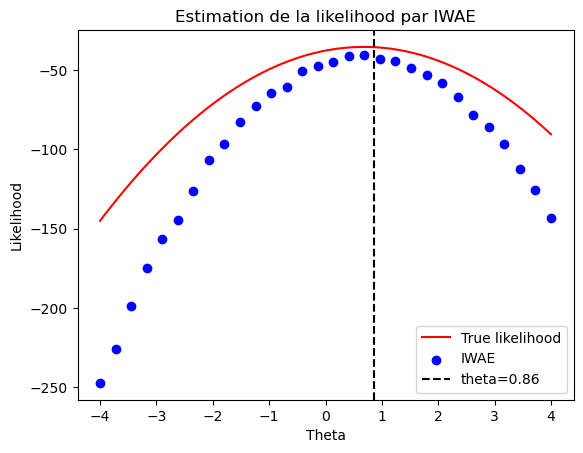

In [18]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(calcul_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_iwae,y_iwae, color='b', label='IWAE')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par IWAE')
plt.legend(loc='best')
plt.show()  

# **6) SUMO ESTIMATOR**

### **a) Estimation function**

In [19]:
def delta_sumo(k, q, p):
    w_k2=[]
    w_k1=[]
    for i in range(k+1):
        w_k1.append(p[i]/q[i])
    for i in range(k+2):
        w_k2.append(p[i]/q[i])
    l_k1 = np.log(np.mean(w_k1))
    l_k2 = np.log(np.mean(w_k2))
    delta_sumo = l_k2-l_k1
    return delta_sumo

In [20]:
def sumo_estimator(n_sim, mean, r, x_data):
    sumo = []
    for i in range(n_sim):
        sum_sumo = 0
        K = np.random.geometric(r, 1)
        z, z_O, z_E = generate_z(K,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
            
        #third step : compute I0
        I0 = w.mean()
        
        for j in range(1,int(K)):
            sum_sumo += (delta_sumo(j,q,p)/((1-r)**j))
            
        ml_ll_sumo = I0 + sum_sumo
        sumo.append(ml_ll_sumo)
        
    mean_value = np.mean(sumo)
    #std_error_value = np.std(sumo) / np.sqrt(len(sumo))

    return mean_value

### **b) Plotting function**

In [21]:
def plot_sumo(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(sumo_estimator(n_sim=300, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

In [22]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_sumo, y_sumo = plot_sumo(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)

Theta = -0.08
0.33
0.67
1.00


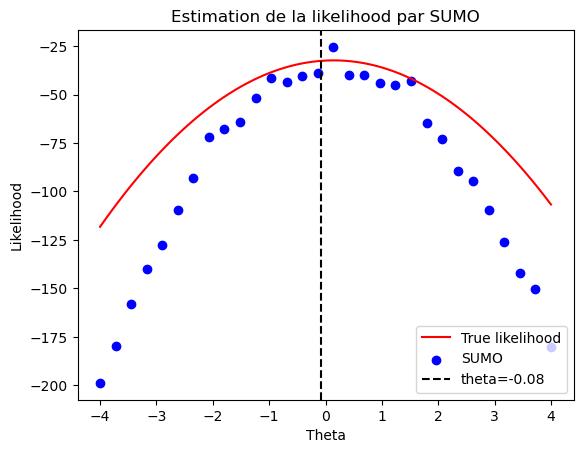

In [23]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(calcul_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_sumo,y_sumo, color='b', label='SUMO')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par SUMO')
plt.legend(loc='best')
plt.show()  

# **All estimators on a single plot**

In [24]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_ss, y_ss = plot_ss(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)
x_rr, y_rr = plot_rr(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)
x_iwae, y_iwae = plot_iwae(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)
x_sumo, y_sumo = plot_sumo(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)

Theta = 0.27
0.33
0.67
1.00
0.33
0.67
1.00
0.33
0.67
1.00
0.33
0.67
1.00


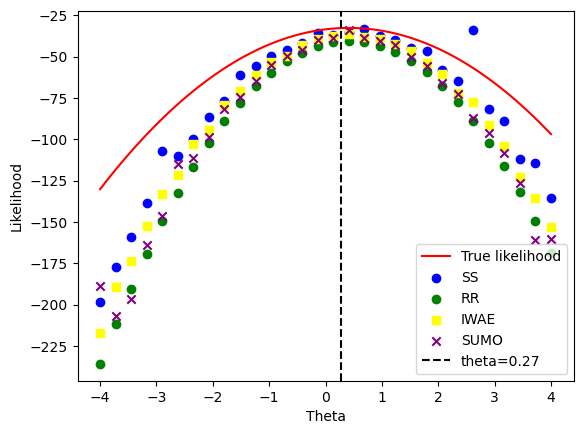

In [25]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(calcul_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')
plt.scatter(x_ss,y_ss, color='b', label='SS')
plt.scatter(x_rr,y_rr, color='green', label='RR')
plt.scatter(x_iwae,y_iwae, color='yellow', marker='s', label='IWAE')
plt.scatter(x_sumo,y_sumo, color='purple', marker='x', label='SUMO')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.legend(loc='best')
plt.show()  